# PROOF OF CONCEPT - START - EPILEPTIC SEIZURE RECOGNITION DATASET

# Signal Processing Final Project proof of concept, recreating the whole procedure in the paper Classification of epileptic EEG recordings using signal transforms and convolutional neural networks

Since I did not find any code online, and the authors did not provide the code, I had to recreate the whole procedure by myself.
I did to the best of my ability to write code to be as close to the paper as possible, and we decided to use the Epileptic Seizure Recognition Dataset.

Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from scipy.signal import butter, filtfilt
from scipy.fft import fft
import pywt
from PyEMD import EMD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

Activating GPU

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found or TensorFlow cannot access the GPU. Using CPU instead.")

GPU is available and will be used.


Loading Data:

In [7]:
df = pd.read_csv("Y:\\Data Science Readings\\Introduction to signal processing\\datasets\\Epileptic Seizure Recognition.csv")

Code For the experiment

In [10]:
def CNNSignalExperiment(
    X, y,
    transform_options = ['raw','fourier','wavelet','emd','ALL'],
    batch_size=50,
    max_epochs=10,
    plot_title="Epileptic Seizure Recognition"
):

    unique_labels = np.unique(y)
    num_classes = len(unique_labels)
    is_binary = (num_classes == 2)

    def butter_bandpass(lowcut, highcut, fs, order=6):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def bandpass_filter(signal_1d, lowcut=0, highcut=60, fs=173.61, order=6):
        b, a = butter_bandpass(lowcut, highcut, fs, order)
        return filtfilt(b, a, signal_1d)

    X_filtered = []
    for i in range(X.shape[0]):
        seg_filt = bandpass_filter(X[i], 0.5, 60, 173.61, order=6)
        X_filtered.append(seg_filt)
    X_filtered = np.array(X_filtered)
    print("After bandpass filtering, X_filtered shape =", X_filtered.shape)



    def raw_transform(signal_1d):
        return signal_1d[np.newaxis, :] 

    def fourier_transform(signal_1d):
        fft_vals = fft(signal_1d)
        half_spectrum = np.abs(fft_vals[: len(signal_1d)//2])  
        
        desired_len = 128
        if len(half_spectrum) < desired_len:
            half_spectrum = np.pad(half_spectrum, (0, desired_len - len(half_spectrum)), 'constant')
        else:
            half_spectrum = half_spectrum[:desired_len]
        return half_spectrum[np.newaxis, :]

    def wavelet_transform(signal_1d):
        coeffs = pywt.wavedec(signal_1d, wavelet='db8', level=5)
        wv = np.concatenate(coeffs, axis=0)
        desired_len = 256
        if len(wv) < desired_len:
            wv = np.pad(wv, (0, desired_len - len(wv)), 'constant')
        else:
            wv = wv[:desired_len]
        return wv[np.newaxis, :]

    def emd_transform(signal_1d, n_imfs=6):
        emd = EMD()
        IMFs = emd(signal_1d)
        if IMFs.shape[0] > n_imfs:
            IMFs = IMFs[:n_imfs, :]
        
        if IMFs.shape[0] < n_imfs:
            needed = n_imfs - IMFs.shape[0]
            extra = np.zeros((needed, IMFs.shape[1]))
            IMFs = np.vstack((IMFs, extra))
        return IMFs  

    def prepare_input_2d(signal_1d, transform='raw'):
        if transform == 'raw':
            return raw_transform(signal_1d)

        elif transform == 'fourier':
            return fourier_transform(signal_1d)

        elif transform == 'wavelet':
            return wavelet_transform(signal_1d)

        elif transform == 'emd':
            return emd_transform(signal_1d, n_imfs=6)

        elif transform == 'ALL':

            raw_ = raw_transform(signal_1d)
            if raw_.shape[1] < 256:
                raw_ = np.pad(raw_, ((0,0),(0,256-raw_.shape[1])), 'constant')
            else:
                raw_ = raw_[:, :256]


            four_ = fourier_transform(signal_1d)
            if four_.shape[1] < 256:
                four_ = np.pad(four_, ((0,0),(0,256-four_.shape[1])), 'constant')
            else:
                four_ = four_[:, :256]

            
            wave_ = wavelet_transform(signal_1d)

           
            emd_ = emd_transform(signal_1d, 6)
            if emd_.shape[1] < 256:
                emd_ = np.pad(emd_, ((0,0),(0,256-emd_.shape[1])), 'constant')
            else:
                emd_ = emd_[:, :256]

            return np.concatenate([raw_, four_, wave_, emd_], axis=0)

        else:
            raise ValueError("Unknown transform: " + transform)

    def transform_dataset(X_array, transform='raw'):
        out_list = []
        for seg in X_array:
            feats_2d = prepare_input_2d(seg, transform)
            feats_3d = feats_2d[..., np.newaxis]
            out_list.append(feats_3d)
        return np.array(out_list)


    def build_cnn_model(input_shape):
        model = Sequential()
        model.add(Conv2D(32, (1,5), padding='same', activation='relu', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(1,3), padding='valid'))
        model.add(Dropout(0.2))
        model.add(Conv2D(32, (1,5), padding='same', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.2))
        if is_binary:
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
        else:
            model.add(Dense(num_classes, activation='softmax'))
            model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        return model



    def train_select_best_epoch(X_train, y_train, X_val, y_val):

        model_temp = build_cnn_model(input_shape=X_train.shape[1:])
        best_epoch = 0
        best_val_acc = 0.0

        for epoch in range(1, max_epochs+1):
            model_temp.fit(X_train, y_train, batch_size=batch_size, epochs=1, verbose=0)
            val_loss, val_acc = model_temp.evaluate(X_val, y_val, verbose=0)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch

        K.clear_session()
        return best_epoch, best_val_acc

    def retrain_and_test(X_trainval, y_trainval, X_test, y_test, best_epoch):
        model_final = build_cnn_model(input_shape=X_trainval.shape[1:])
        model_final.fit(X_trainval, y_trainval, batch_size=batch_size, epochs=best_epoch, verbose=0)
        test_loss, test_acc = model_final.evaluate(X_test, y_test, verbose=0)
        K.clear_session()
        return test_acc


    def get_fold_assignments(n_folds=5, X_data=None, y_data=None, random_state=42):
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
        all_folds = []
        for _, idx in enumerate(skf.split(X_data, y_data)):
            all_folds.append(idx)

        test_folds = [all_folds[i][1] for i in range(n_folds)]
        all_indices = np.arange(X_data.shape[0])
        fold_assignments = []
        for i in range(n_folds):
            test_idx = test_folds[i]
            val_idx  = test_folds[(i+1) % n_folds]
            test_val_union = np.union1d(test_idx, val_idx)
            train_idx = np.setdiff1d(all_indices, test_val_union)
            fold_assignments.append((train_idx, val_idx, test_idx))
        return fold_assignments


    n_repeats = 3


    results = {t: None for t in transform_options}
    results_std = {t: None for t in transform_options}

    fold_assignments = get_fold_assignments(n_folds=5, X_data=X_filtered, y_data=y, random_state=42)
    for transform in transform_options:
        print(f"\n=== Transform: {transform} ===")
        fold_acc_list = []

        for i, (train_idx, val_idx, test_idx) in enumerate(fold_assignments):
            print(f" Fold {i+1} => train={len(train_idx)}, val={len(val_idx)}, test={len(test_idx)}")
            X_tr_raw = X_filtered[train_idx]
            y_tr     = y[train_idx]
            X_val_raw= X_filtered[val_idx]
            y_val    = y[val_idx]
            X_test_raw= X_filtered[test_idx]
            y_test   = y[test_idx]
            X_train_tf = transform_dataset(X_tr_raw, transform=transform)
            X_val_tf   = transform_dataset(X_val_raw, transform=transform)
            X_test_tf  = transform_dataset(X_test_raw, transform=transform)

            repeat_accs = []
            for rep in range(n_repeats):
                best_epoch, best_val_acc = train_select_best_epoch(
                    X_train_tf, y_tr,
                    X_val_tf, y_val
                )

                X_trainval_tf = np.concatenate([X_train_tf, X_val_tf], axis=0)
                y_trainval    = np.concatenate([y_tr, y_val], axis=0)
                test_acc = retrain_and_test(
                    X_trainval_tf, y_trainval,
                    X_test_tf, y_test,
                    best_epoch
                )
                repeat_accs.append(test_acc)


            mean_test_acc = np.mean(repeat_accs)
            fold_acc_list.append(mean_test_acc)
            print(f" => Fold {i+1} average test_acc over repeats: {mean_test_acc:.4f}")

        overall_mean = np.mean(fold_acc_list)
        overall_std  = np.std(fold_acc_list)
        results[transform]     = overall_mean
        results_std[transform] = overall_std

        print(f"\nTransform [{transform}] => 5-fold mean={overall_mean:.4f}, std={overall_std:.4f}")


    print("\n===== FINAL RESULTS =====")
    for t in transform_options:
        print(f"{t:>8s} => mean={results[t]:.4f}, std={results_std[t]:.4f}")



    def plot_errorbar_means(results, results_std, plot_title=""):
        transforms = list(results.keys())
        means = [results[t] for t in transforms]
        stds  = [results_std[t] for t in transforms]
        x_positions = np.arange(len(transforms))
    
        plt.figure(figsize=(8,6))
        plt.errorbar(
            x_positions, means,
            yerr=stds,
            fmt='o',
            ecolor='black',
            capsize=5,
            markersize=2,
            color='blue'
        )
        plt.xticks(x_positions, transforms)
        plt.ylabel("Accuracy")
        plt.title(plot_title)
        plt.ylim([0.4, 1.05]) 
        for y in np.arange(0, 1.05, 0.05):
            plt.axhline(y=y, color='gray', linestyle='--', alpha=0.5)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
    
    plot_errorbar_means(results, results_std, plot_title=plot_title)

    return results, results_std

# How to read the y values in the dataset(numbers 1,2,3,4,5) and what they represent in the scientific paper (F,N,S,O,Z)

On the left side we have numbers, which are the labels in the dataset, on the right side we have letters, which represent the categories defined in the paper.

5 - eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open - Z

4 - eyes closed, means when they were recording the EEG signal the patient had their eyes closed - O

3 - Yes they identify where the region of the tumor was in the brain and recording the EEG activity from the healthy brain area - N

2 - They recorder the EEG from the area where the tumor was located - F

1 - Recording of seizure activity - S

# Experiment 1: Focal vs. Non-focal (Fig.4 in the paper)

After bandpass filtering, X_filtered shape = (4600, 177)

=== Transform: raw ===
 Fold 1 => train=2760, val=920, test=920
 => Fold 1 average test_acc over repeats: 0.7051
 Fold 2 => train=2760, val=920, test=920
 => Fold 2 average test_acc over repeats: 0.7264
 Fold 3 => train=2760, val=920, test=920
 => Fold 3 average test_acc over repeats: 0.7250
 Fold 4 => train=2760, val=920, test=920
 => Fold 4 average test_acc over repeats: 0.7264
 Fold 5 => train=2760, val=920, test=920
 => Fold 5 average test_acc over repeats: 0.7203

Transform [raw] => 5-fold mean=0.7207, std=0.0081

=== Transform: emd ===
 Fold 1 => train=2760, val=920, test=920
 => Fold 1 average test_acc over repeats: 0.6457
 Fold 2 => train=2760, val=920, test=920
 => Fold 2 average test_acc over repeats: 0.6464
 Fold 3 => train=2760, val=920, test=920
 => Fold 3 average test_acc over repeats: 0.6609
 Fold 4 => train=2760, val=920, test=920
 => Fold 4 average test_acc over repeats: 0.6373
 Fold 5 => train=2760, val=920, te

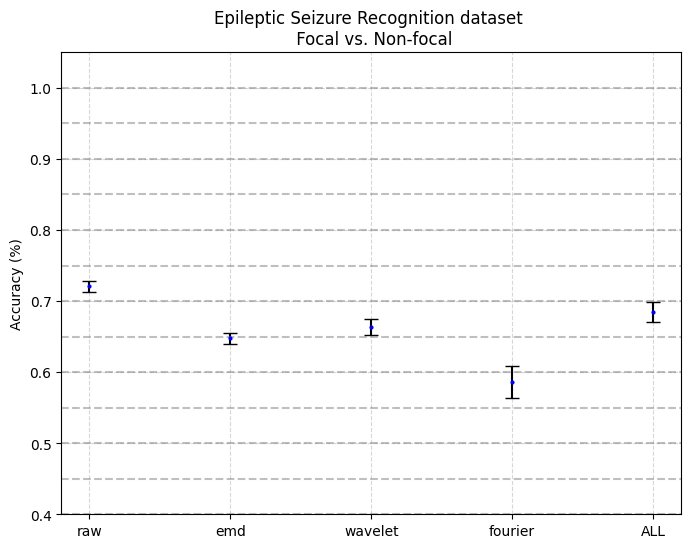

({'raw': 0.720652174949646,
  'emd': 0.6476811607678731,
  'wavelet': 0.6629710117975871,
  'fourier': 0.58594202597936,
  'ALL': 0.6847101410230001},
 {'raw': 0.008111401573982895,
  'emd': 0.00758139420433015,
  'wavelet': 0.011238659319753602,
  'fourier': 0.022377583924225307,
  'ALL': 0.013913042719169003})

In [15]:
df_focal_vs_nonfocal = df[df['y'].isin([2, 3])]
X_full = df_focal_vs_nonfocal.iloc[:, 1:179-1].values  
y_labels = df_focal_vs_nonfocal.iloc[:, -1].values     
y_labels_binary = (y_labels == 2).astype(int)   
CNNSignalExperiment(
    X=X_full,
    y=y_labels_binary,
    transform_options = ['raw','emd','wavelet','fourier','ALL'], 
    batch_size=50,
    max_epochs=50,
    plot_title="Epileptic Seizure Recognition dataset \n Focal vs. Non-focal"
)

# Experiment 2: Healthy (Z) vs. Ictal (S) (Fig.8 in the paper)

After bandpass filtering, X_filtered shape = (4600, 177)

=== Transform: raw ===
 Fold 1 => train=2760, val=920, test=920
 => Fold 1 average test_acc over repeats: 0.9946
 Fold 2 => train=2760, val=920, test=920
 => Fold 2 average test_acc over repeats: 0.9967
 Fold 3 => train=2760, val=920, test=920
 => Fold 3 average test_acc over repeats: 0.9978
 Fold 4 => train=2760, val=920, test=920
 => Fold 4 average test_acc over repeats: 0.9692
 Fold 5 => train=2760, val=920, test=920
 => Fold 5 average test_acc over repeats: 0.9957

Transform [raw] => 5-fold mean=0.9908, std=0.0109

=== Transform: emd ===
 Fold 1 => train=2760, val=920, test=920
 => Fold 1 average test_acc over repeats: 0.9899
 Fold 2 => train=2760, val=920, test=920
 => Fold 2 average test_acc over repeats: 0.9891
 Fold 3 => train=2760, val=920, test=920
 => Fold 3 average test_acc over repeats: 0.9899
 Fold 4 => train=2760, val=920, test=920
 => Fold 4 average test_acc over repeats: 0.9902
 Fold 5 => train=2760, val=920, te

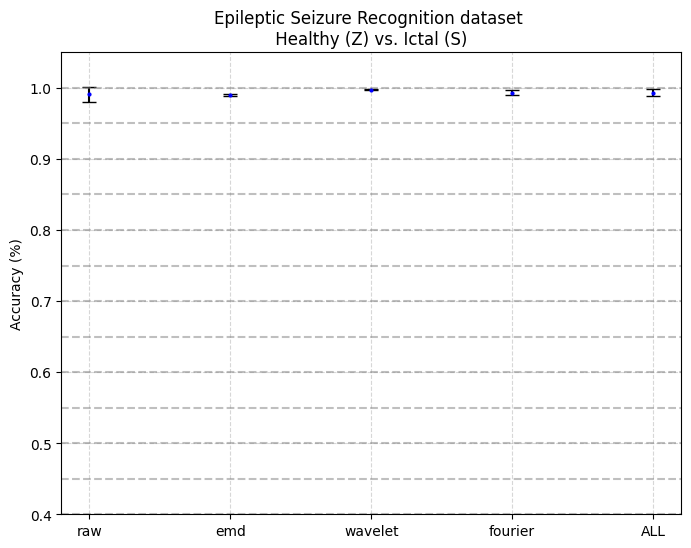

({'raw': 0.9907971103986105,
  'emd': 0.990289851029714,
  'wavelet': 0.9973188440004984,
  'fourier': 0.9932608723640441,
  'ALL': 0.9929710189501444},
 {'raw': 0.010851682014765648,
  'emd': 0.0011084852519820296,
  'wavelet': 0.0008755859241218049,
  'fourier': 0.0033254534179686865,
  'ALL': 0.004710697786451692})

In [17]:
df_healthy_vs_ictal = df[df['y'].isin([1, 5])]
X_full_ex2 = df_healthy_vs_ictal.iloc[:, 1:179-1].values  
y_labels_ex2 = df_healthy_vs_ictal.iloc[:, -1].values    
y_labels_binary_ex2 = (y_labels_ex2 == 1).astype(int)   
CNNSignalExperiment(
    X=X_full_ex2,
    y=y_labels_binary_ex2,
    transform_options = ['raw','emd','wavelet','fourier','ALL'],
    batch_size=50,
    max_epochs=50,
    plot_title="Epileptic Seizure Recognition dataset \n Healthy (Z) vs. Ictal (S) "
)

# Experiment 3: Non-Ictal (N) vs. Ictal (S) (Fig.8 in the paper)

After bandpass filtering, X_filtered shape = (4600, 177)

=== Transform: raw ===
 Fold 1 => train=2760, val=920, test=920
 => Fold 1 average test_acc over repeats: 0.9877
 Fold 2 => train=2760, val=920, test=920
 => Fold 2 average test_acc over repeats: 0.9801
 Fold 3 => train=2760, val=920, test=920
 => Fold 3 average test_acc over repeats: 0.9859
 Fold 4 => train=2760, val=920, test=920
 => Fold 4 average test_acc over repeats: 0.9928
 Fold 5 => train=2760, val=920, test=920
 => Fold 5 average test_acc over repeats: 0.9884

Transform [raw] => 5-fold mean=0.9870, std=0.0041

=== Transform: emd ===
 Fold 1 => train=2760, val=920, test=920
 => Fold 1 average test_acc over repeats: 0.9870
 Fold 2 => train=2760, val=920, test=920
 => Fold 2 average test_acc over repeats: 0.9833
 Fold 3 => train=2760, val=920, test=920
 => Fold 3 average test_acc over repeats: 0.9826
 Fold 4 => train=2760, val=920, test=920
 => Fold 4 average test_acc over repeats: 0.9895
 Fold 5 => train=2760, val=920, te

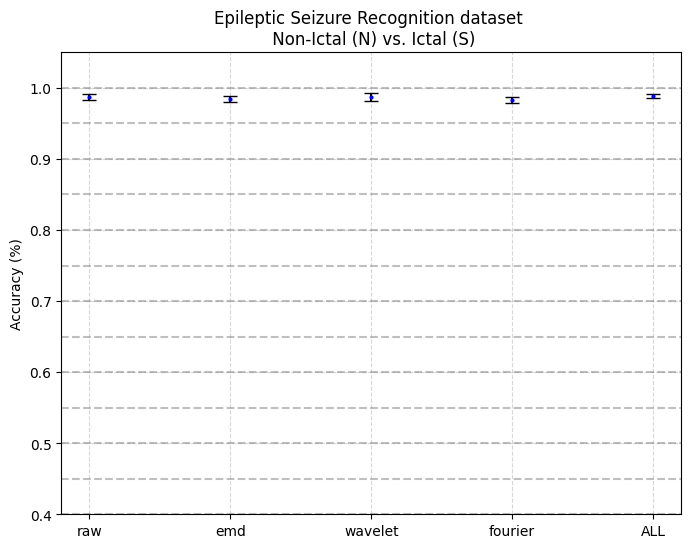

({'raw': 0.986956524848938,
  'emd': 0.9838405768076578,
  'wavelet': 0.9871014515558878,
  'fourier': 0.9830434799194336,
  'ALL': 0.9884057958920796},
 {'raw': 0.004118342782668182,
  'emd': 0.004309007039526089,
  'wavelet': 0.006244507581096464,
  'fourier': 0.0038165828640897466,
  'ALL': 0.0031834516285389586})

In [23]:
df_nonictal_vs_ictal = df[df['y'].isin([1, 3])]
X_full_ex3 = df_nonictal_vs_ictal.iloc[:, 1:179-1].values  
y_labels_ex3 = df_nonictal_vs_ictal.iloc[:, -1].values     
y_labels_binary_ex3 = (y_labels_ex3 == 1).astype(int)   
CNNSignalExperiment(
    X=X_full_ex3,
    y=y_labels_binary_ex3,
    transform_options = ['raw','emd','wavelet','fourier','ALL'],
    batch_size=50,
    max_epochs=50,
    plot_title="Epileptic Seizure Recognition dataset \n Non-Ictal (N) vs. Ictal (S)"
)

# Experiment 4: Healthy(Z) vs. Interictal(N). vs Ictal(S) (Fig.8 in the paper)

After bandpass filtering, X_filtered shape = (6900, 177)

=== Transform: raw ===
 Fold 1 => train=4140, val=1380, test=1380
 => Fold 1 average test_acc over repeats: 0.9290
 Fold 2 => train=4140, val=1380, test=1380
 => Fold 2 average test_acc over repeats: 0.8758
 Fold 3 => train=4140, val=1380, test=1380
 => Fold 3 average test_acc over repeats: 0.9184
 Fold 4 => train=4140, val=1380, test=1380
 => Fold 4 average test_acc over repeats: 0.9418
 Fold 5 => train=4140, val=1380, test=1380
 => Fold 5 average test_acc over repeats: 0.9517

Transform [raw] => 5-fold mean=0.9233, std=0.0263

=== Transform: emd ===
 Fold 1 => train=4140, val=1380, test=1380
 => Fold 1 average test_acc over repeats: 0.9188
 Fold 2 => train=4140, val=1380, test=1380
 => Fold 2 average test_acc over repeats: 0.9401
 Fold 3 => train=4140, val=1380, test=1380
 => Fold 3 average test_acc over repeats: 0.9384
 Fold 4 => train=4140, val=1380, test=1380
 => Fold 4 average test_acc over repeats: 0.9121
 Fold 5 => train

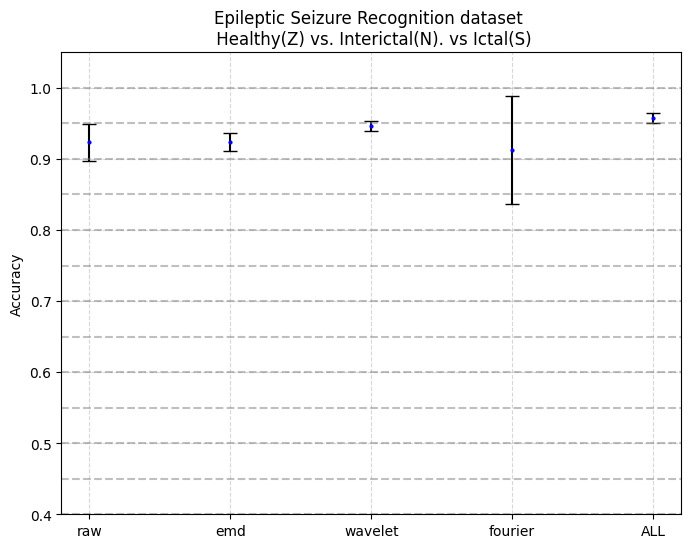

({'raw': 0.9233333309491476,
  'emd': 0.9241545915603637,
  'wavelet': 0.9464734276135763,
  'fourier': 0.9126570045948028,
  'ALL': 0.957536232471466},
 {'raw': 0.026292620032212083,
  'emd': 0.012611383357155755,
  'wavelet': 0.0070531439291415705,
  'fourier': 0.07584273766925317,
  'ALL': 0.006994657494821589})

In [12]:
df_healthy_vs_interictal_ictal = df[df['y'].isin([5,3,1])]

exp4_mapping = {5:0,1:1,3:2}
X_full_ex4 = df_healthy_vs_interictal_ictal.iloc[:, 1:179-1].values  
df_healthy_vs_interictal_ictal['y_new'] = df_healthy_vs_interictal_ictal['y'].map(exp4_mapping)
y_labels_ex4 = df_healthy_vs_interictal_ictal.iloc[:, -1].values     

CNNSignalExperiment(
    X=X_full_ex4,
    y=y_labels_ex4,
    transform_options =['raw','emd','wavelet','fourier','ALL'], 
    batch_size=50,
    max_epochs=50,
    plot_title="Epileptic Seizure Recognition dataset \n Healthy(Z) vs. Interictal(N). vs Ictal(S)"
)

# Experiment 5: Healthy(Z) vs. Interictal(f). vs Ictal(S) (Fig.8 in the paper)

After bandpass filtering, X_filtered shape = (6900, 177)

=== Transform: raw ===
 Fold 1 => train=4140, val=1380, test=1380
 => Fold 1 average test_acc over repeats: 0.9307
 Fold 2 => train=4140, val=1380, test=1380
 => Fold 2 average test_acc over repeats: 0.9048
 Fold 3 => train=4140, val=1380, test=1380
 => Fold 3 average test_acc over repeats: 0.9176
 Fold 4 => train=4140, val=1380, test=1380
 => Fold 4 average test_acc over repeats: 0.9278
 Fold 5 => train=4140, val=1380, test=1380
 => Fold 5 average test_acc over repeats: 0.9155

Transform [raw] => 5-fold mean=0.9193, std=0.0093

=== Transform: emd ===
 Fold 1 => train=4140, val=1380, test=1380
 => Fold 1 average test_acc over repeats: 0.9324
 Fold 2 => train=4140, val=1380, test=1380
 => Fold 2 average test_acc over repeats: 0.9307
 Fold 3 => train=4140, val=1380, test=1380
 => Fold 3 average test_acc over repeats: 0.9348
 Fold 4 => train=4140, val=1380, test=1380
 => Fold 4 average test_acc over repeats: 0.9280
 Fold 5 => train

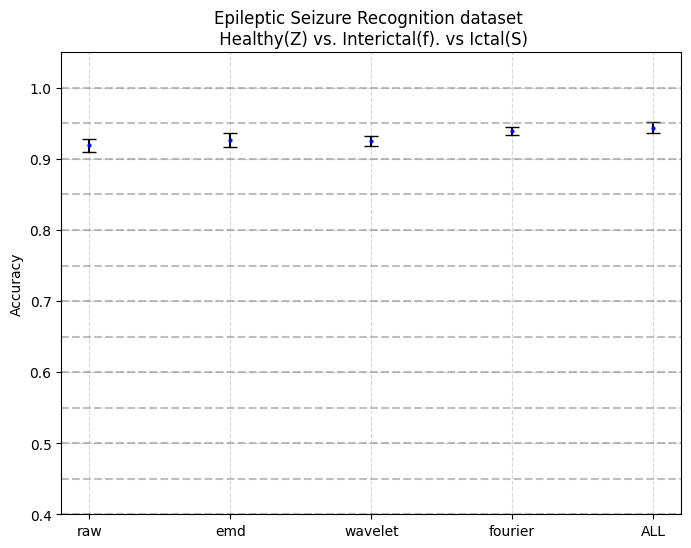

({'raw': 0.9192753632863363,
  'emd': 0.9268115957578023,
  'wavelet': 0.9246376872062683,
  'fourier': 0.9396135250727335,
  'ALL': 0.9438164273897807},
 {'raw': 0.009253951933173939,
  'emd': 0.009557407472710633,
  'wavelet': 0.007071977575312716,
  'fourier': 0.00560886681746492,
  'ALL': 0.007611720015061797})

In [13]:
df_zfs = df[df['y'].isin([5,2,1])]

exp5_mapping = {5:0,1:1,2:2}
X_full_ex5 = df_zfs.iloc[:, 1:179-1].values  
df_zfs['y_new'] = df_zfs['y'].map(exp5_mapping)
y_labels_ex5 = df_zfs.iloc[:, -1].values     

CNNSignalExperiment(
    X=X_full_ex5,
    y=y_labels_ex5,
    transform_options = ['raw','emd','wavelet','fourier','ALL'],
    batch_size=50,
    max_epochs=50,
    plot_title="Epileptic Seizure Recognition dataset \n Healthy(Z) vs. Interictal(f). vs Ictal(S)"
)

# PROOF OF CONCEPT - END - EPILEPTIC SEIZURE RECOGNITION DATASET